In [1]:
#! /usr/bin/python2.7

'''A script that contains data concerning the pipe, discretization,
prior- and likelihood functions. In this script the friction
coefficient is assumed to be scalar.


Parameters
----------

expan_coef: int
size of friction coefficient vector

uni_prior_down: float * expan_coef
lower bound for the uniform prior

uni_prior_up: float * expan_coef
upper bound for the uniform prior

initial_point_mcmc: float * expan_coef
initial point in the MCMC sampler

c_sound: float
sound speed

t_final: float
final time

x_l: float
left boundary of the domain

x_r: float
right boundary of the domain

dx: float
mesh size

boundary_eps: float
a number for computing pressure drop at both ends of the pipe

pipe_true: SemiLinSystem
an object that represents and contains attributes of the true pipe

pipe: SemiLinSystem 
an object that represents and contains attributes
of a pipe used during MCMC for sampling

'''

from UQuant.SemilinearSystem import SemiLinSystem

from numpy.random import normal
from numpy import pi, exp, dot
from numpy import empty
from bisect import bisect
from math  import isnan

# stochastic settings
uni_prior_down = [0.05]
uni_prior_up   = [0.5]

sigma_normal   = 0.05
initial_point_mcmc = [0.45]
expan_coef = 1

# physical settings
c_sound = 1.0
t_final = 5.0
x_l, x_r = [0.0, 1.0]
dx = 0.005
boundary_eps = 0.05

# true friction coefficient
true_friction = [0.075]
time_ins = 20
time_ins_fine = 100

# construct and run the true pipe
pipe_true = SemiLinSystem(c_sound, t_final, x_l, x_r, dx, expan_coef, 
                          boundary_eps)
pipe_true.run(true_friction)

y_obs_true = pipe_true.get_presure_drop(time_instance=time_ins_fine, inplace=False)

y_obs_times = pipe_true.timeslices

Address of the pipe in the memory from python:  0x179f970


In [2]:
def isclose(a, b, rel_tol=1e-06, abs_tol=0.0):
    '''
    check if two floats are close
    '''
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

def iscloselist(a, List):
    ''' 
    check if a float is close to an element of a list
    '''
    for idx, item in enumerate(List):
        if isclose(a, item):
            return idx
    return None

In [3]:
class GasBayesianInversion(object):
    '''
    GasBayesianInversion solves a Bayesian Inverse 
    problem for Gas pipe friction coefficients.
    '''
    
    def __init__(self, c_sound, t_final, x_l, x_r, dx, expan_coef, boundary_eps, time_ins):
        from UQuant.SemilinearSystem import SemiLinSystem
    
        self.c_sound, self.t_final = c_sound, t_final
        
        self.x_l, self.x_r = x_l, x_r
        
        self.dx, self.expan_coef, self.boundary_eps = dx, expan_coef, boundary_eps
        
        self.time_ins = time_ins
        
        self.pipe = SemiLinSystem(c_sound, t_final, x_l, x_r, dx, expan_coef, boundary_eps)
         
    
    @staticmethod
    def EvalY_obs(timeslices, y_obs, y_obs_times):
        '''
        evaluates a given time_instances on y_obs.

        Parameters
        ----------

        time_instances: float * len(time_instances)

        '''

        out = empty(len(timeslices), dtype=float)    

        for idx, time in enumerate(timeslices):
            inList = iscloselist(time, y_obs_times)
            if inList!=None:
                out[idx] = y_obs[inList]
            else:
                right = bisect(y_obs_times, time)
                left  = right - 1
                if left < 0:
                    out[idx] = y_obs[right]
                elif right >= len(y_obs_times):
                    out[idx] = y_obs[left]
                else:
                    out[idx] = 0.5*(y_obs[right]+y_obs[left])
        return out

    def uni_prior(self, x):
        '''
        uniform prior

        Parameters
        ----------

        x: float * len(x)
        '''

        volume = 1.0

        for i in range(len(x)):
            volume *= abs(uni_prior_up[i] - uni_prior_down[i])

        normalize = 1.0 / volume

        for i in range(len(x)):
            if ( ((x[i]<uni_prior_up[i]) & (x[i]>uni_prior_down[i]))==False ):
                return 0.0

        return normalize

    def proposal_density(self, new, old):
        '''
        proposal density function

        Parameters
        ----------
        new: float * len(new)

        old: float * len(old)
        '''

        length = len(new)

        out = empty(length, dtype=float)

        for i in range(length):
            out[i] = 1.0/(2*pi*sigma_normal**2) * \
                     exp( -0.5*(new[i] - old[i])**2 / sigma_normal**2 )

        return out

    def draw_from_proposal(self, old):
        '''
        draw from the proposal

        Parameters
        ----------
        old: float * len(old)
        '''
        return normal(old, sigma_normal, size=len(old))

    def likelihood(self, x):
        '''
        computes the likelihood function

        Parameters
        ----------

        pipe: SemiLinSystem

        x: float * len(x)
        '''

        pipe = self.pipe
        
        pipe.run(x, progress_bool=False)

        # check if we have negative friction
        pipe.get_current_lambda_average()
        for i in pipe.lambda_avg:
            if i<0: return 0.0

        S = pipe.get_presure_drop(time_instance=self.time_ins, inplace=False)

        Proj_y_obs = self.EvalY_obs(pipe.timeslices, self.y_obs, self.y_obs_true_times)

        out = exp( -0.5 * dot(S - Proj_y_obs, S - Proj_y_obs) / self.epsilon )

        #print (out, self.epsilon)
        
        return out

    def density(self, x):
        '''
        density function for the MCMC: 
        multiplication of the likelihood and the prior distribution

        Parameters
        ----------
        x: float * len(x)

        '''
        PRIOR = self.uni_prior(x)
        if PRIOR > 10.0**-8:
            return self.likelihood(x) * PRIOR
        else:
            return 0.0

    def run_mcmc(self, epsilon, y_obs_true, y_obs_true_times, 
                 initial_point_mcmc, max_iter=2000, burning=500, jupyter=False):
        '''
        run_mcmc takes an epsilon and compute the y_obs and then run mcmc using those observations.

        Returns
        -------

        samples: list
        '''
        from UQuant.mcmc import MCMC
        
        self.epsilon = epsilon
        
        self.y_obs = normal(0.0, epsilon, time_ins_fine) + y_obs_true
        
        self.y_obs_true_times = y_obs_true_times
            
        self.mcmc = MCMC(self.density, 
                         self.proposal_density, 
                         self.draw_from_proposal, 
                         initial_point_mcmc)
        
        
        self.mcmc.run(max_iter=max_iter, burning=burning, jupyter=jupyter)

In [4]:
def GBI_thread(epsilon):
    '''
    for multi-threading
    '''
    gbi = GasBayesianInversion(c_sound, t_final, x_l, x_r, dx, expan_coef, boundary_eps, time_ins)
    gbi.run_mcmc(epsilon, y_obs_true, y_obs_times, initial_point_mcmc, 
                 max_iter=1500, burning=200, jupyter=True)
    
    return (epsilon, [pt[0] for pt in gbi.mcmc.density_samples])

In [5]:
import multiprocessing
from numpy import arange

EPSILONS = list(arange(0.25, 10., 0.5))
NUM_THREAD = 20
pool = multiprocessing.Pool(NUM_THREAD)
results = pool.map_async(GBI_thread, EPSILONS)

pool.close()
pool.join()

Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the pipe in the memory from python:  0x17db3e0
Address of the

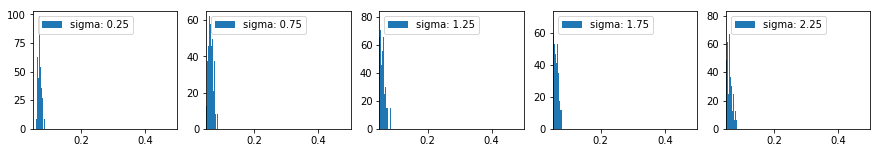

In [9]:
import matplotlib.pyplot as plt

results_list = results.get()
fig = plt.figure(figsize=(15, 10))
N_ROW = 4
for idx, (sigma, result) in enumerate(results_list[:5]):
    ax = fig.add_subplot(N_ROW, len(results_list)//N_ROW, idx+1)
    tmp = ax.hist(result,  normed=True, bins=40, label="sigma: {}".format(sigma))
    ax.set_xlim(uni_prior_down[0], uni_prior_up[0])
    ax.legend(loc='upper left')

In [12]:
fig.savefig("/Home/varioper/hajian/UQ/results/sigma.png")

# Testing